## Ensemble Explorer

In this notebook you will see how to:

- compute and plot ensemble mean and spread maps
- create a stamp plot
- create a spaghetti plot
- compute and plot ensemble probability and percentile maps
- generate a CDF (Cumulative Distribution Function) plot for a given location

You will work with the following earthkit components:
- [earthkit-data](https://earthkit-data.readthedocs.io/en/latest/)
- [earthkit-plots](https://earthkit-plots.readthedocs.io/en/latest/)
- [earthkit-transforms](https://earthkit-transforms.readthedocs.io/en/latest/)
- [earthkit-geo](https://earthkit-geo.readthedocs.io/en/latest/)

#### The input data

The data to work with is related to the St Jude wind storm from 2013 October. The windgust and the 850 hPa geopotential forecast were retrieved from MARS in GRIB format for a few steps on a low resolution grid to provide input for the exercises. For convenience, this data is available as an earthkit-data "sample". You can find details about how this data was actually generated with earthkit-data in the "ensemble_from_mars.ipynb" notebook.

The data is loaded into 2 GRIB fieldlists.

In [1]:
import earthkit as ek

ds_fc = ek.data.from_source("sample", "fc_storm_st_jude.grib") # hi-res forecast
ds_en = ek.data.from_source("sample", "ens_storm_st_jude.grib") # ensemble forecast

You can get an overview of what the fieldlists contain using `ls()`. Notice the `dataType` for the ensemble data: "cf" means control forecast, "pf" means perturbed member forecast.

In [2]:
ds_fc.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,10fg3,surface,0,20131025,0,69-72,fc,0,regular_ll
1,ecmf,10fg3,surface,0,20131025,0,75-78,fc,0,regular_ll
2,ecmf,10fg3,surface,0,20131025,0,81-84,fc,0,regular_ll
3,ecmf,z,isobaricInhPa,850,20131025,0,72,fc,0,regular_ll
4,ecmf,z,isobaricInhPa,850,20131025,0,78,fc,0,regular_ll
5,ecmf,z,isobaricInhPa,850,20131025,0,84,fc,0,regular_ll


In [3]:
ds_en.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,10fg3,surface,0,20131025,0,69-72,cf,0,regular_ll
1,ecmf,10fg3,surface,0,20131025,0,75-78,cf,0,regular_ll
2,ecmf,10fg3,surface,0,20131025,0,81-84,cf,0,regular_ll
3,ecmf,10fg3,surface,0,20131025,0,69-72,pf,1,regular_ll
4,ecmf,10fg3,surface,0,20131025,0,69-72,pf,2,regular_ll
...,...,...,...,...,...,...,...,...,...,...
301,ecmf,z,isobaricInhPa,850,20131025,0,84,pf,46,regular_ll
302,ecmf,z,isobaricInhPa,850,20131025,0,84,pf,47,regular_ll
303,ecmf,z,isobaricInhPa,850,20131025,0,84,pf,48,regular_ll
304,ecmf,z,isobaricInhPa,850,20131025,0,84,pf,49,regular_ll


### Compute the ensemble mean and spread

Some of the exercises will require the ensemble mean and spread of the windgust. High-level computations on GRIB fieldlists are not yet available in  [earthkit-data](https://earthkit-data.readthedocs.io/en/latest/). Therefore, you will carry out these computations in Xarray using [earthkit-transforms](https://earthkit-transforms.readthedocs.io/en/latest/). Since the ensemble fieldlist forms a full hypercube you can convert it to Xarray using the default options.

In [4]:
# select windgust fields and convert them to Xarray
ds_fg = ds_en.sel(param="10fg3")
fg = ds_fg.to_xarray()

# compute ensemble mean and spread
fg_mean = ek.transforms.ensemble.mean(fg)
fg_spread = ek.transforms.ensemble.std(fg)

#### Create an ensemble plot

This example creates a 2x2 plot for a given timestep (=78h) of the windgust forecast. The maps in the plot shows the following fields:

- deterministic forecast
- control forecast
- ensemble mean
- ensemble spread

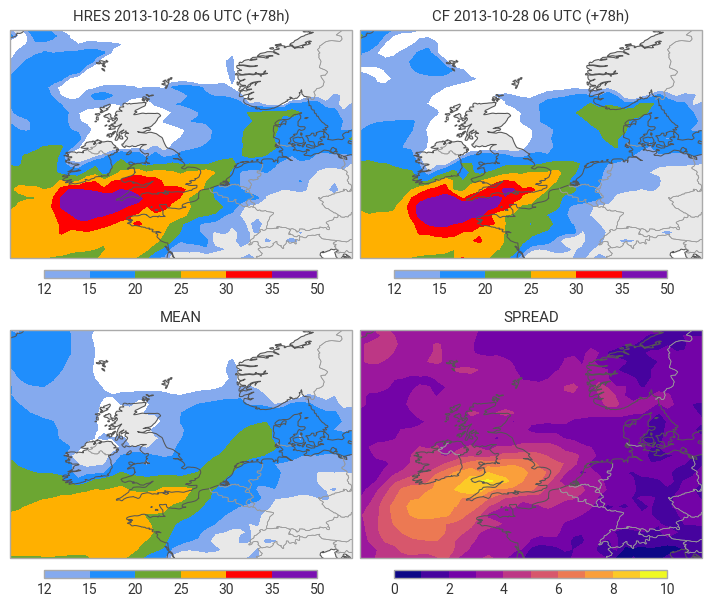

In [5]:
import earthkit.plots 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime

figure = earthkit.plots.Figure(crs=ccrs.PlateCarree(), 
                               domain=[-15,15,65,45], size=(7, 6), rows=2, columns=2)

gust_style = earthkit.plots.styles.Style(
    colors=["#85AAEE", "#208EFC", "#6CA632", "#FFB000", "#FF0000", "#7A11B1"],
    levels=[12, 15, 20, 25, 30, 35, 50],
    units="m s-1",
)

# the hres forecast, GRIB
subplot = figure.add_map(0, 0)
subplot.contourf(ds_fc.sel(param="10fg3", step=78), style=gust_style)
subplot.title("HRES {time:%Y-%m-%d %H} UTC (+{lead_time}h)")
subplot.legend(label="")

# the control forecast, GRIB
subplot = figure.add_map(0, 1)
subplot.contourf(ds_fg.sel(marsType="cf", step=78), style=gust_style)
subplot.title("CF {time:%Y-%m-%d %H} UTC (+{lead_time}h)")
subplot.legend(label="")

# the ensemble mean, Xarray
subplot = figure.add_map(1, 0)
subplot.contourf(fg_mean.sel(step=datetime.timedelta(hours=78)),  style=gust_style)
subplot.title("MEAN")
subplot.legend(label="")

# the ensemble spread, Xarray
subplot = figure.add_map(1, 1)
subplot.contourf(fg_spread.sel(step=datetime.timedelta(hours=78)))
subplot.title("SPREAD")
subplot.legend(label="")

figure.land()
figure.coastlines()
figure.borders()

figure.show()

### Creating a stamp plot

In a stamp plot all the ensemble members are plotted into a different map within the same plot. It provides us with a quick overview on how the forecast members differ from each other. 

A stamp plot is about managing the layout. The code below creates an 8x8 grid and plots the ensmeble mean, the HRES forecast and the control forecast into the first row, and the perturbed members into the rest of the cells.

TypeError: unsupported operand type(s) for -: 'list' and 'list'

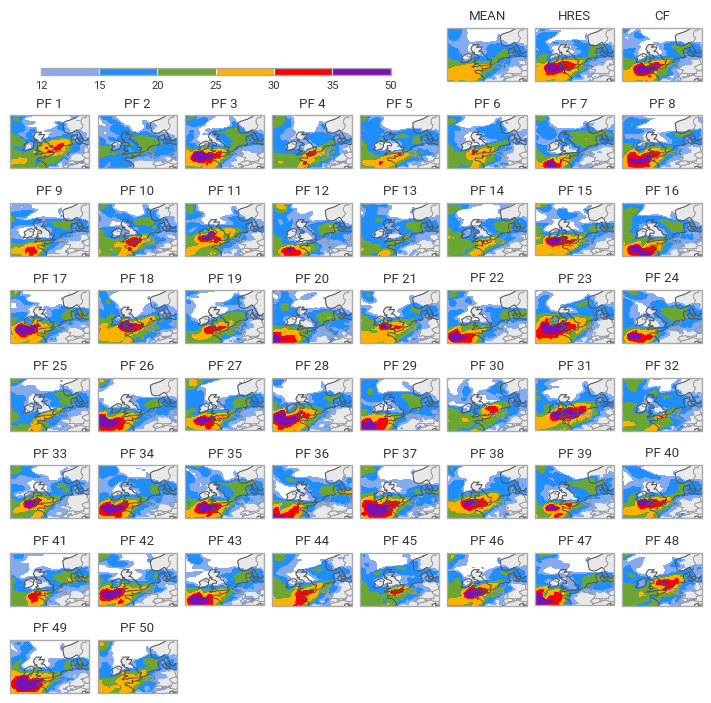

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

figure = ek.plots.Figure(crs=ccrs.PlateCarree(), domain=[-15,15,65,45], size=(7, 7), rows=8, columns=8)

gust_style = ek.plots.styles.Style(
    colors=["#85AAEE", "#208EFC", "#6CA632", "#FFB000", "#FF0000", "#7A11B1"],
    levels=[12, 15, 20, 25, 30, 35, 50],
    units="m s-1",
)

gust_style_1 = earthkit.plots.styles.Contour(
    linecolors="black",
    levels=[12, 15, 20, 25, 30, 35, 50],
    linewidths=1,
    labels=False,
    units="m s-1",
)

# ensemble mean, Xarray
subplot = figure.add_map(0, 5)
subplot.contourf(fg_mean.sel(step=datetime.timedelta(hours=78)), style=gust_style)
subplot.title("MEAN")

# HRES forecast, GRIB
subplot = figure.add_map(0, 6)
subplot.contourf(ds_fc.sel(param="10fg3", step=78), style=gust_style)
subplot.title("HRES")

# control forecast, GRIB
subplot = figure.add_map(0, 7)
subplot.contourf(ds_fg.sel(dataType="cf", step=78), style=gust_style)
subplot.title("CF")

# perturbed members, GRIB
for i, f in enumerate(ds_fg.sel(dataType="pf", step=78)):
    subplot = figure.add_map(1+i//8, i%8)
    subplot.contourf(f, style=gust_style)
    subplot.title("PF {number}")

figure.land(resolution="low")
figure.coastlines(resolution="low")
figure.borders(resolution="low")

ax = plt.axes((0.05, 0.9, 0.5, 0.01))
legends = figure.legend(ax=ax, label="")
legends[0].ax.tick_params(labelsize=8)

# figure.subplot_titles("{time:%Y-%m-%d %H} UTC (+{lead_time}h)")

figure.title(
    "ECMWF Run: {base_time!1:%Y-%m-%d %H} UTC (+{lead_time!1}h)\n{variable_name!1}",
    fontsize=9, horizontalalignment="left", x=0, y=0.96,
)

figure.show()

### Creating a spaghetti plot

In a spaghetti plot we pick an isoline value and plot that isoline into the same map from all the ensemble members. It is a useful tool e.g. to investigate the uncertainty of the location of a trough associated with a storm.

This exercise shows you how to generate a spaghetti plot for the 850 hPa geopotential forecast.

First, the geopotential  data is extracted for the selected timestep.

In [7]:
z_fc = ds_fc.sel(param="z", level=850, step=78)
z_en = ds_en.sel(param="z", level=850, step=78)

Next, the perturbed members, the control forecast and the hi-res forecast are plotted into the same map.

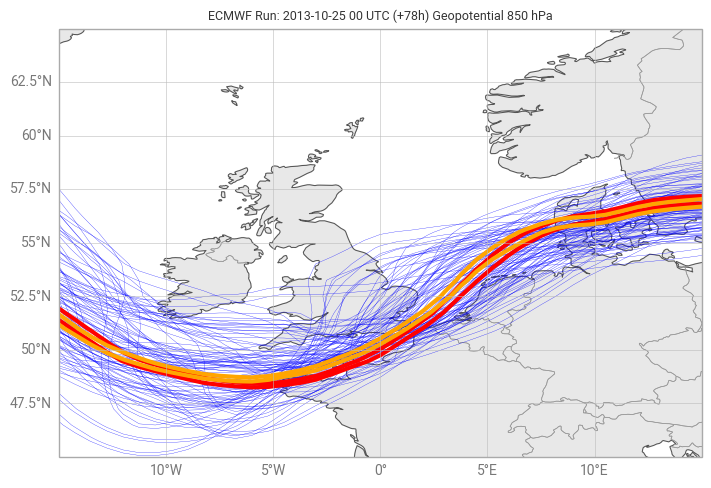

In [9]:
chart = ek.plots.Map(crs=ccrs.PlateCarree(), domain=[-15, 15, 65, 45], size=(7,7)) 

# perturbed members
for f in z_en.sel(dataType="pf"):
    chart.contour(f, levels=[12500,12600], linewidths=[0.2, 0.2],linecolors="blue", labels=False)

# control forecast
chart.contour(z_en.sel(dataType="cf"), levels=[12500,12600], linewidths=[3, 3],linecolors="red", labels=False)

# hres forecasts
chart.contour(z_fc, levels=[12500,12600], linewidths=[3, 3],linecolors="orange", labels=False)
    
chart.land()
chart.coastlines()
chart.borders()
chart.gridlines()

chart.title(
    "ECMWF Run: {base_time:%Y-%m-%d %H} UTC (+{lead_time}h) {variable_name} {level} hPa",
    fontsize=9
)

chart.show()

### Generating a probability map

This exercise shows you compute the probability of having a wind gust exceeding a given threshold for a given timestep. 

The computations are carried out in Xarray.

In [ ]:
threshold = 28 
prob = ds_fg.to_xarray() > threshold
prob = prob.mean(dim="number") * 100

In [ ]:
# define step
step=78

chart = ek.plots.Map(crs=ccrs.PlateCarree(), domain=[-15, 15, 65, 45], size=(7,7)) 

prob_style = ek.plots.styles.Style(
    levels=[10,20,30,40,50,60,72],
)

chart.contourf(prob.sel(step=datetime.timedelta(hours=step)), style=prob_style)
chart.land()
chart.coastlines()
chart.borders()
chart.gridlines()
chart.legend()
chart.title("{variable_name} (+" +str(step) + " h) probability (> " + str(threshold) + " m/s)", 
            fontsize=9)

chart.show()

### Generating a percentile map

Another way of looking at the probabilities is to use a percentile map which give you a more detailed view about the actual distribution of the ENS forecast values. 

This example shows how to generate the percentile map for 80%. The value in each gridpoint will be the windgust value below which 80% of the ENS members fall.

The computations are carried out in Xarray.

In [ ]:
perc = 0.8 # 80%
prob = ds_fg.to_xarray()
prob = prob.quantile(perc, dim="number")

In [ ]:
# define step
step=78

chart = ek.plots.Map(crs=ccrs.PlateCarree(), domain=[-15, 15, 65, 45], size=(7,7)) 

chart.contourf(prob.sel(step=datetime.timedelta(hours=step)), style=gust_style)
chart.land()
chart.coastlines()
chart.borders()
chart.gridlines()
chart.legend()
chart.title("{variable_name} (+" +str(step) + " h) percentile " + str(perc*100) + " %", 
            fontsize=9)

chart.show()

#### Creating a CDF plot

CDF (Cumulative Distribution Function) curves can be used to study the forecast probabilities at a given location in detail. The CDF curve constructed form ENS data tells us the probability that the forecast will be less than or equal to a given value.

In this example the CDF plot is built for the location of Reading for 3 consecutive time steps (72, 78 and 84 h). The index of the grid point to extract from each field is determined by using  [earthkit.geo.nearest_point_haversine()](https://earthkit-geo.readthedocs.io/en/latest/_api/geo/distance/index.html#geo.distance.nearest_point_haversine).

In [ ]:
import numpy as np

p_ref = (51.45, -0.97)
latlon = ds_fg[0].to_latlon()
lat = latlon["lat"]
lon = latlon["lon"]

idx, dist = ek.geo.nearest_point_haversine(p_ref, (lat, lon))
idx

lines = []
for step in [72, 78, 84]:
    x = ds_fg.sel(step=step).to_numpy(index=idx, flatten=True)

    # form cdf
    y = np.arange(0, 101)
    x = np.percentile(x, y)

    # make line plot object
    line, = plt.plot(x, y, label=f"step={step}h")
    lines.append(line)

plt.legend(handles=lines, loc='lower right')
plt.xlabel('Wind gust (m/s)')
plt.ylabel('Percentage (%)')
plt.show()